### 1. Identify high-amplitude channel

Top channels by mean paired-peak amplitude:
#1: Channel 39 — mean amplitude = 1794.2
#2: Channel 133 — mean amplitude = 1665.2
#3: Channel 330 — mean amplitude = 1607.0
#4: Channel 179 — mean amplitude = 1537.2
#5: Channel 148 — mean amplitude = 1491.6


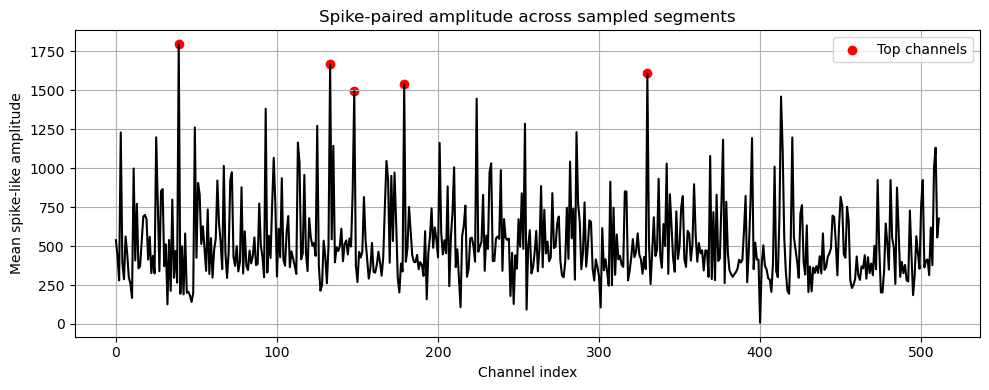

In [1]:
# Step 1 (refined): Robust dominant channel detection based on paired spike-like events
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.signal import find_peaks

# --- Parameters ---
dat_path = '/Volumes/Lab/Users/alexth/axolotl/201703151_data001.dat'  # CHANGE THIS
n_channels = 512
dtype = np.int16
segment_len = 100000  # samples per segment (~0.5s at 20 kHz)
n_segments = 10
seed = 42
peak_window = 30   # look for post-peak maxima within ±30 samples
top_k_neg = 20     # find this many negative peaks per channel per segment
top_k_events = 5   # use top K events per channel across all segments

# --- Open file and determine total samples ---
bytes_per_sample = np.dtype(dtype).itemsize
with open(dat_path, 'rb') as f:
    f.seek(0, 2)
    file_len_bytes = f.tell()
    total_samples = file_len_bytes // (bytes_per_sample * n_channels)

# --- Sample random time segments ---
rng = np.random.default_rng(seed)
start_indices = rng.integers(0, total_samples - segment_len, size=n_segments)

# --- Collect spike-like amplitudes ---
channel_amplitudes = [[] for _ in range(n_channels)]

for start in start_indices:
    with open(dat_path, 'rb') as f:
        offset_bytes = start * n_channels * bytes_per_sample
        f.seek(offset_bytes)
        raw = np.fromfile(f, dtype=dtype, count=n_channels * segment_len)
        segment = raw.reshape((segment_len, n_channels)).T  # shape: [C x T]

    for ch in range(n_channels):
        trace = segment[ch].astype(np.float32)
        trace -= trace.mean()

        # --- Find large negative peaks ---
        neg_peaks, _ = find_peaks(-trace, distance=20)
        if len(neg_peaks) == 0:
            continue

        # Sort by amplitude (most negative first)
        sorted_idx = np.argsort(trace[neg_peaks])  # increasing → more negative
        neg_peaks = neg_peaks[sorted_idx[:top_k_neg]]

        for peak_idx in neg_peaks:
            win_start = max(peak_idx - peak_window, 0)
            win_end = min(peak_idx + peak_window + 1, segment_len)
            local_max = np.max(trace[win_start:win_end])
            amplitude = local_max - trace[peak_idx]
            channel_amplitudes[ch].append(amplitude)

# --- For each channel, compute mean of top spike-like amplitudes ---
mean_amplitudes = np.zeros(n_channels)
for ch in range(n_channels):
    amps = np.array(channel_amplitudes[ch])
    if len(amps) == 0:
        mean_amplitudes[ch] = 0
    else:
        top_amps = np.sort(amps)[-top_k_events:]  # largest amplitudes
        mean_amplitudes[ch] = np.mean(top_amps)

# --- Report top channels ---
top_n = 5
top_channels = np.argsort(mean_amplitudes)[-top_n:][::-1]
print("Top channels by mean paired-peak amplitude:")
for i, ch in enumerate(top_channels):
    print(f"#{i+1}: Channel {ch} — mean amplitude = {mean_amplitudes[ch]:.1f}")

# --- Optional plot ---
plt.figure(figsize=(10, 4))
plt.plot(mean_amplitudes, color='black')
plt.scatter(top_channels, mean_amplitudes[top_channels], color='red', label='Top channels')
plt.xlabel("Channel index")
plt.ylabel("Mean spike-like amplitude")
plt.title("Spike-paired amplitude across sampled segments")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



### 2. Define spike threshold

Loaded 10000000 samples for channel 39
368.3976135253906
Top 100 event amplitudes (mean = 1803.6):
[1877. 1877. 1873. 1873. 1868. 1865. 1857. 1851. 1823. 1822. 1819. 1816.
 1809. 1808. 1807. 1807. 1807. 1807. 1806. 1805. 1804. 1804. 1804. 1803.
 1803. 1803. 1803. 1802. 1802. 1801. 1801. 1801. 1801. 1801. 1801. 1801.
 1800. 1800. 1799. 1799. 1798. 1797. 1797. 1797. 1797. 1797. 1797. 1797.
 1797. 1797. 1797. 1796. 1796. 1796. 1796. 1796. 1796. 1795. 1795. 1795.
 1795. 1795. 1795. 1795. 1795. 1795. 1795. 1794. 1794. 1794. 1794. 1794.
 1794. 1794. 1794. 1794. 1793. 1793. 1793. 1793. 1793. 1793. 1792. 1792.
 1792. 1792. 1792. 1792. 1792. 1792. 1792. 1791. 1791. 1791. 1791. 1791.
 1791. 1791. 1791. 1791.]


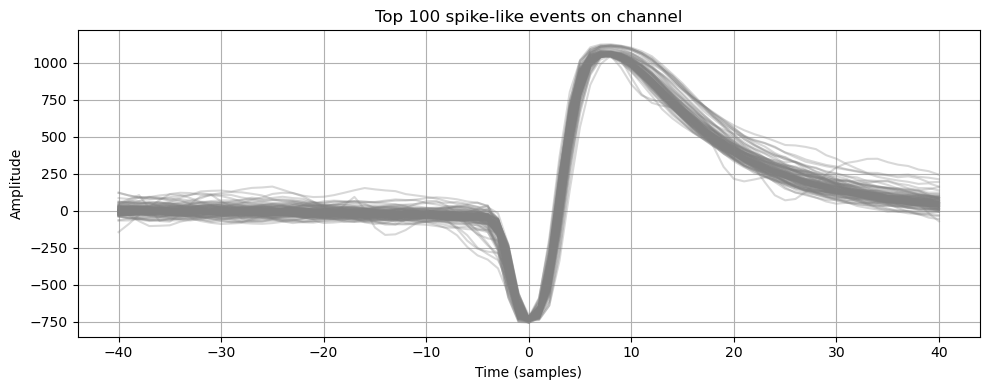

In [2]:
# Step 2: Read single channel and find 100 largest spike-like events
import numpy as np
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

# --- Parameters ---
dat_path = '/Volumes/Lab/Users/alexth/axolotl/201703151_data001.dat'  # CHANGE THIS
n_channels = 512
target_channel = top_channels[0]                 # CHANGE THIS based on Step 1 output
dtype = np.int16
total_samples_to_read = 10_000_000
block_size = 100_000                 # Number of timepoints per block
refractory = 30                      # Enforce 60-sample exclusion window
window = 30                          # ±window around neg peak to find post-peak

# --- Allocate storage ---
trace = np.zeros(total_samples_to_read, dtype=np.float32)

# --- Read block-by-block ---
bytes_per_sample = np.dtype(dtype).itemsize
samples_read = 0
with open(dat_path, 'rb') as f:
    while samples_read < total_samples_to_read:
        samples_to_load = min(block_size, total_samples_to_read - samples_read)
        offset_bytes = samples_read * n_channels * bytes_per_sample
        f.seek(offset_bytes)
        raw = np.fromfile(f, dtype=dtype, count=samples_to_load * n_channels)
        if len(raw) != samples_to_load * n_channels:
            break
        block = raw.reshape((samples_to_load, n_channels))
        trace[samples_read:samples_read+samples_to_load] = block[:, target_channel]
        samples_read += samples_to_load

print(f"Loaded {samples_read} samples for channel {target_channel}")

# --- Detrend by subtracting mean ---
trace -= np.mean(trace)

# --- Detect negative peaks with refractory ---
neg_peaks, _ = find_peaks(-trace, distance=2 * refractory)

# --- Extract amplitudes (pos_peak - neg_peak) ---
event_amplitudes = []
event_indices = []

for idx in neg_peaks:
    win_start = max(idx - window, 0)
    win_end = min(idx + window + 1, len(trace))
    pos_peak = np.max(trace[win_start:win_end])
    amp = pos_peak - trace[idx]
    event_amplitudes.append(amp)
    event_indices.append(idx)

event_amplitudes = np.array(event_amplitudes)
event_indices = np.array(event_indices)

# --- Keep top 100 events ---
top_n = 100
if len(event_amplitudes) >= top_n:
    top_idx = np.argsort(event_amplitudes)[-top_n:]
else:
    top_idx = np.argsort(event_amplitudes)

top_idx = np.argsort(event_amplitudes)[-100:]  # high-to-low amplitude events
ref_neg_peaks = trace[event_indices[top_idx]]  # extract their negative peaks
threshold = 0.5 * np.mean(np.abs(ref_neg_peaks))  # threshold is 0.5× mean(abs(neg_peak))
print(threshold)

top_amps = event_amplitudes[top_idx]
top_locs = event_indices[top_idx]

# --- Report and plot ---
print(f"Top {len(top_amps)} event amplitudes (mean = {np.mean(top_amps):.1f}):")
print(np.round(top_amps[::-1], 1))  # print descending

plt.figure(figsize=(10, 4))
for loc in top_locs:
    start = max(loc - 40, 0)
    end = min(loc + 41, len(trace))
    snippet = trace[start:end]
    plt.plot(np.arange(start - loc, end - loc), snippet, alpha=0.3, color='gray')
plt.title("Top 100 spike-like events on channel")
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.tight_layout()
plt.show()


### 3. Detect suprathreshold events

Threshold (neg peak only): -368.4
Detected 1456 events exceeding threshold.
Threshold: 368.4
Detected 1456 events exceeding threshold.


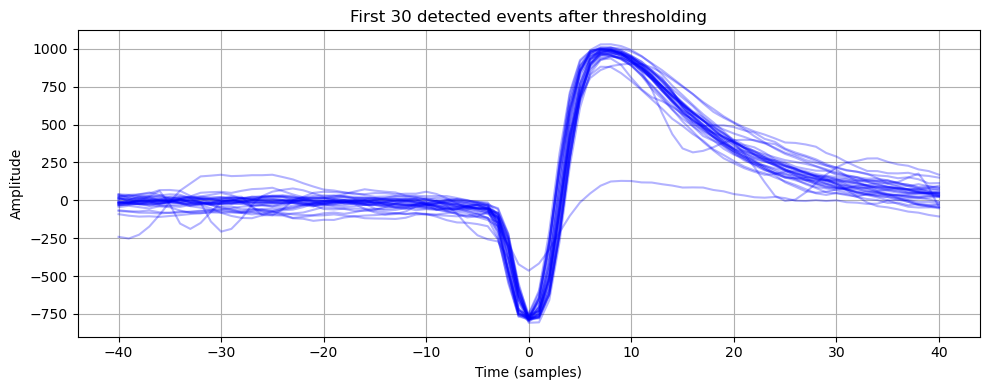

In [3]:
# Step 3: Threshold-based spike detection using local baseline subtraction
from scipy.ndimage import uniform_filter1d
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

# --- Inputs (from previous steps) ---
# trace: already loaded 10M trace for target_channel
# top_amps: 100 largest spike-like amplitudes from Step 2

# --- Parameters ---
refractory = 30          # same as before
threshold_frac = 0.5     # threshold is 0.5 × mean(top amplitudes)
baseline_window = 20001  # ~1 second @ 20 kHz

# --- Local baseline subtraction ---
trace_filtered = trace - uniform_filter1d(trace, size=baseline_window, mode='nearest')

# --- Negative peak detection with refractory ---
neg_peaks, _ = find_peaks(-trace_filtered, distance=2 * refractory)

# --- Filter events crossing threshold ---
# --- Apply threshold to baseline-subtracted trace ---
selected_peaks = [idx for idx in neg_peaks if trace_filtered[idx] < -threshold]
selected_peaks = np.array(selected_peaks)

print(f"Threshold (neg peak only): -{threshold:.1f}")
print(f"Detected {len(selected_peaks)} events exceeding threshold.")

print(f"Threshold: {threshold:.1f}")
print(f"Detected {len(selected_peaks)} events exceeding threshold.")

# --- Optional: Plot a few examples ---
plt.figure(figsize=(10, 4))
for idx in selected_peaks[:30]:
    start = max(idx - 40, 0)
    end = min(idx + 41, len(trace_filtered))
    snippet = trace_filtered[start:end]
    plt.plot(np.arange(start - idx, end - idx), snippet, alpha=0.3, color='blue')
plt.title("First 30 detected events after thresholding")
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.tight_layout()
plt.show()


### 4. Extract snippets around detected spikes (all channels)

In [4]:
# Step 4: Extract multi-channel snippets for all spike events
from extract_data_snippets import extract_snippets

# --- Inputs ---
# selected_peaks: array of spike sample indices from Step 3
# dat_path: same .dat file
# target_window: time window around spike (samples)
# dtype: must match your raw file (likely 'int16')
# n_channels: usually 512

target_window = (-20, 60)  # pre/post in samples
dtype = np.int16
n_channels = 512

snips = extract_snippets(
    dat_path=dat_path,
    spike_times=selected_peaks,
    window=target_window,
    n_channels=n_channels,
    dtype=dtype
)

print(f"Extracted snippets shape: {snips.shape}  (channels × time × spikes)")


Extracted snippets shape: (512, 81, 1456)  (channels × time × spikes)


### Step 5: Compute and visualize the EI

EI shape: (512, 81)


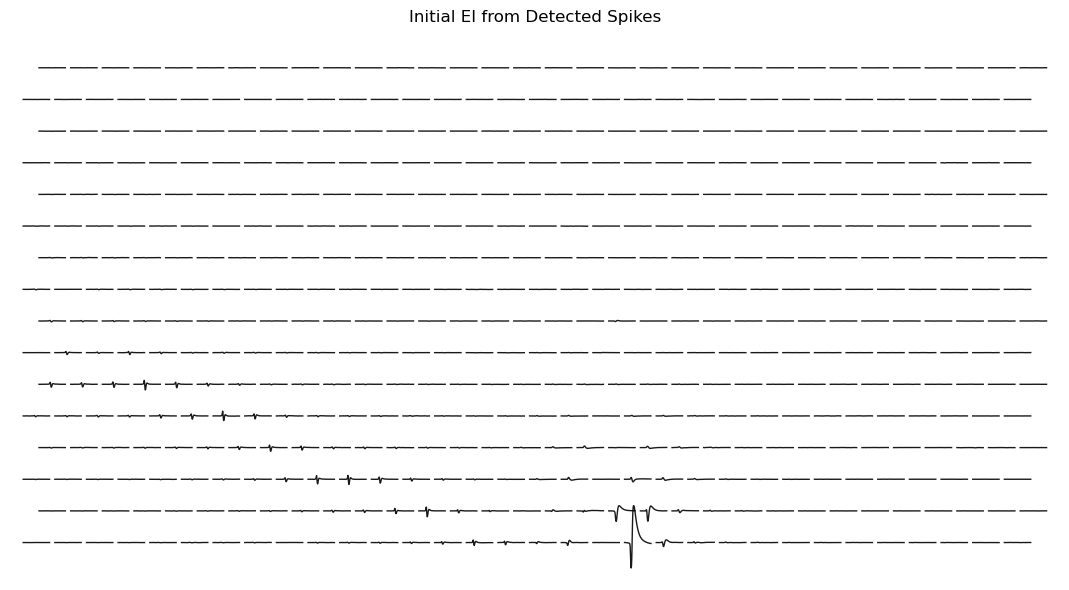

In [5]:
# Step 5: Compute and visualize the EI
import numpy as np
from plot_ei_waveforms import plot_ei_waveforms
import h5py

h5_in_path = '/Volumes/Lab/Users/alexth/axolotl/201703151_kilosort_data001_spike_times.h5'  # from MATLAB export

with h5py.File(h5_in_path, 'r') as f:
    # Load electrode positions
    ei_positions = f['/ei_positions'][:].T  # shape becomes [512 x 2]


# --- Inputs ---
# snips: [512, 81, N_spikes] from Step 4
# ei_positions: [512, 2] electrode locations (you must load this)

def compute_ei(snips, baseline_samples=5):
    ei = np.mean(snips, axis=2)
    ei -= ei[:, :baseline_samples].mean(axis=1, keepdims=True)
    return ei

# --- Compute EI ---
ei = compute_ei(snips)
print(f"EI shape: {ei.shape}")

# --- Plot EI ---
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
plot_ei_waveforms(
    ei=ei,
    positions=ei_positions,
    scale=70.0,
    box_height=1.0,   # can adjust for visibility
    box_width=50,
    linewidth=1,
    alpha=0.9,
    colors='black'
)
plt.title("Initial EI from Detected Spikes")
plt.tight_layout()
plt.show()


### 6. Cluster spikes using waveforms on selected EI channels

Selected 80 EI channels.


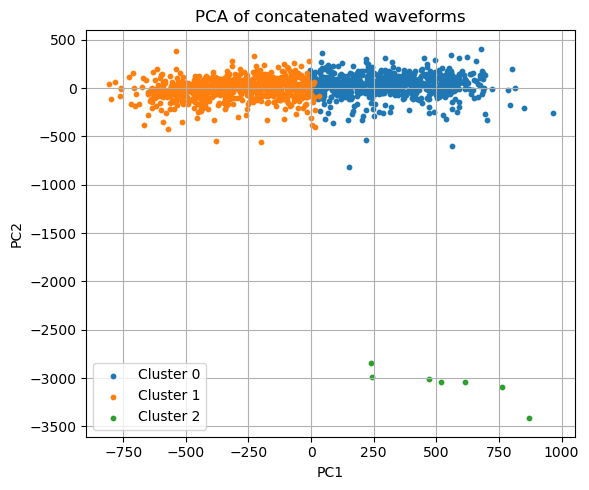

{0: 718, 1: 731, 2: 7}


In [6]:
# Step 6: Cluster spikes using waveforms from selected EI channels
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# --- Parameters ---
min_chan = 30
max_chan = 80
p2p_threshold = 15  # in raw units, to select active channels
k_clusters = 3
window_centering = True

# --- Select EI channels with large p2p ---
ei_p2p = ei.max(axis=1) - ei.min(axis=1)
selected_channels = np.where(ei_p2p > p2p_threshold)[0]
if len(selected_channels) > max_chan:
    selected_channels = np.argsort(ei_p2p)[-max_chan:]
elif len(selected_channels) < min_chan:
    selected_channels = np.argsort(ei_p2p)[-min_chan:]
selected_channels = np.sort(selected_channels)
print(f"Selected {len(selected_channels)} EI channels.")

# --- Extract waveform data for those channels ---
snips_sel = snips[selected_channels, :, :]  # shape: [C x T x N]
C, T, N = snips_sel.shape

# --- Flatten for PCA: [spikes x (C*T)] ---
snips_centered = snips_sel - snips_sel.mean(axis=1, keepdims=True)  # center per channel
snips_flat = snips_centered.transpose(2, 0, 1).reshape(N, -1)

# --- PCA ---
pca = PCA(n_components=10)
pcs = pca.fit_transform(snips_flat)

# --- KMeans clustering ---
kmeans = KMeans(n_clusters=k_clusters, n_init=10, random_state=42)
labels = kmeans.fit_predict(pcs)

# --- Plot PCA space ---
plt.figure(figsize=(6, 5))
for k in np.unique(labels):
    cluster_pcs = pcs[labels == k]
    plt.scatter(cluster_pcs[:, 0], cluster_pcs[:, 1], s=10, label=f"Cluster {k}")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA of concatenated waveforms")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Store cluster indices ---
cluster_spike_indices = {k: np.where(labels == k)[0] for k in np.unique(labels)}
print({k: len(v) for k, v in cluster_spike_indices.items()})


### Step 6b: Cluster EIs + Similarity Matrix

In [7]:
# Step 6b: Compute EI for each cluster and similarity matrix
from compare_eis import compare_eis

cluster_eis = []
cluster_ids = sorted(cluster_spike_indices.keys())
for k in cluster_ids:
    inds = cluster_spike_indices[k]
    ei_k = np.mean(snips[:, :, inds], axis=2)
    ei_k -= ei_k[:, :5].mean(axis=1, keepdims=True)
    cluster_eis.append(ei_k)

# --- Similarity matrix ---
sim = compare_eis(cluster_eis)
print("EI similarity matrix:")
print(np.round(sim, 3))




EI similarity matrix:
[[1.    0.983 0.245]
 [0.983 1.    0.263]
 [0.245 0.263 1.   ]]


### Step 6c: Merge Based on EI Similarity

In [8]:
# Step 6c: Merge clusters with EI similarity ≥ threshold
import networkx as nx
import numpy as np

sim_threshold = 0.9
n_clusters = len(cluster_ids)

# --- Build graph ---
G = nx.Graph()
G.add_nodes_from(range(n_clusters))
for i in range(n_clusters):
    for j in range(i + 1, n_clusters):
        if sim[i, j] >= sim_threshold:
            G.add_edge(i, j)

# --- Connected components = merged clusters ---
merged_groups = list(nx.connected_components(G))
merged_clusters = []

print("Merged cluster groups:")
for group in merged_groups:
    group = sorted(list(group))
    print(f"  Group {group}")
    all_inds = np.concatenate([cluster_spike_indices[cluster_ids[i]] for i in group])
    merged_clusters.append(np.sort(all_inds))

print(f"\nFinal cluster count after merging: {len(merged_clusters)}")


Merged cluster groups:
  Group [0, 1]
  Group [2]

Final cluster count after merging: 2


### Step 6d: Plot EIs of All Merged Clusters

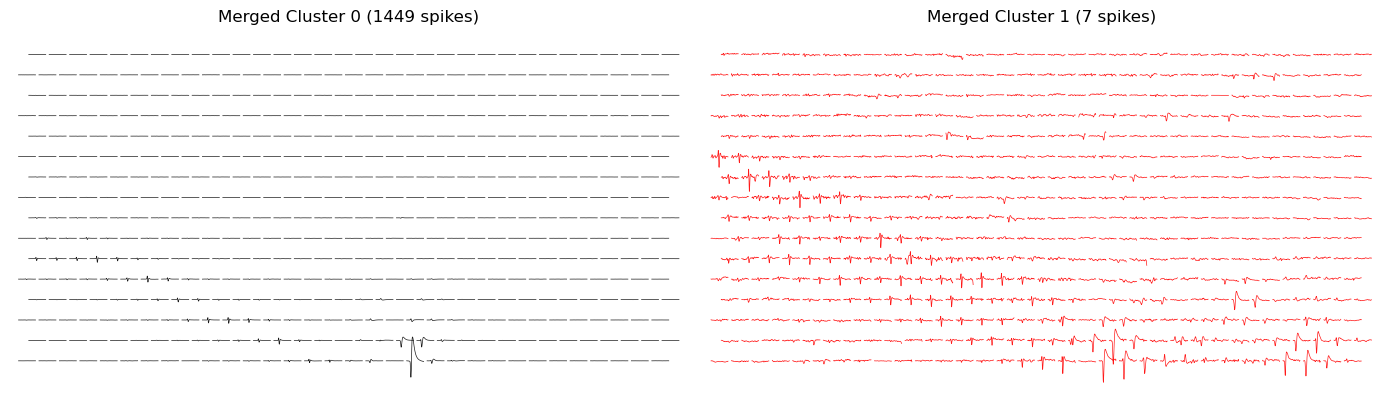

In [9]:
# Step 6d: Plot EI of each merged cluster
from plot_ei_waveforms import plot_ei_waveforms
import matplotlib.pyplot as plt

n_merged = len(merged_clusters)
n_cols = min(n_merged, 4)
n_rows = (n_merged + n_cols - 1) // n_cols

fig, axs = plt.subplots(n_rows, n_cols, figsize=(7 * n_cols, 7 * n_rows))
axs = axs.flatten() if n_merged > 1 else [axs]

# --- Define colors (adjust or expand as needed) ---
colors = ['black', 'red', 'blue', 'green', 'purple', 'orange', 'brown', 'teal', 'magenta', 'olive']


for i, inds in enumerate(merged_clusters):
    ei_i = np.mean(snips[:, :, inds], axis=2)
    ei_i -= ei_i[:, :5].mean(axis=1, keepdims=True)

    color = colors[i % len(colors)]

    ax = axs[i]
    plot_ei_waveforms(
        ei=ei_i,
        positions=ei_positions,
        ax=ax,
        scale=70.0,
        box_height=1.0,   # can adjust for visibility
        box_width=50,
        linewidth=0.5,
        alpha=0.9,
        colors=color
    )
    ax.set_title(f"Merged Cluster {i} ({len(inds)} spikes)")

# Turn off unused subplots
for j in range(i+1, len(axs)):
    axs[j].axis('off')

plt.tight_layout()
plt.show()


### Step 7: Select the dominant cluster.

In [10]:
# Step 7: Select dominant cluster based on top_channel EI amplitude
top_channel = target_channel  # ← replace with actual top channel from Step 1

amplitudes = []
cluster_eis = []

for inds in merged_clusters:
    ei_i = np.mean(snips[:, :, inds], axis=2)
    ei_i -= ei_i[:, :5].mean(axis=1, keepdims=True)
    cluster_eis.append(ei_i)

    peak_to_peak = ei_i[top_channel, :].max() - ei_i[top_channel, :].min()
    amplitudes.append(peak_to_peak)

amplitudes = np.array(amplitudes)
best_idx = np.argmax(amplitudes)

print(f"Selected cluster: {best_idx}")
print(f"Amplitude on channel {top_channel}: {amplitudes[best_idx]:.1f}")
print(f"Spike count: {len(merged_clusters[best_idx])}")

# Extract selected cluster's EI and spikes
selected_ei = cluster_eis[best_idx]
selected_spike_inds = merged_clusters[best_idx]


Selected cluster: 0
Amplitude on channel 39: 1755.9
Spike count: 1449


### Step 8: EI Pursuit

In [11]:
import numpy as np
import scipy.io as sio
from run_multi_gpu_ei_scan import run_multi_gpu_ei_scan
from scipy.signal import argrelextrema

# --- Save EI template to .mat ---
ei_template_path = '/Volumes/Lab/Users/alexth/axolotl/ei_template_test.mat'
sio.savemat(ei_template_path, {'ei_template': selected_ei.astype(np.float32)})

# --- Set pursuit parameters ---
total_samples = 10_000_000  # or full length
save_prefix = '/Volumes/Lab/Users/alexth/axolotl/ei_scan_unit0'  # unique name for outputs

# --- Run multi-GPU pursuit ---
mean_score, max_score, valid_score, selected_channels, ei_template_used = run_multi_gpu_ei_scan(
    ei_mat_path=ei_template_path,
    dat_path=dat_path,
    total_samples=total_samples,
    save_prefix=save_prefix,
    dtype='int16',
    block_size=None,
    baseline_start_sample=0
)

# --- Post-process scores into spike times ---
# Threshold based on mean or fixed value
score_threshold = max(np.mean(mean_score) / 2, 10000)
peaks = argrelextrema(mean_score, np.greater_equal, order=1)[0]
valid_inds = peaks[(mean_score[peaks] > score_threshold) & (valid_score[peaks] > 3)]
final_spike_times = valid_inds + 20  # aligns to center of window

print(f"Final spike count from EI pursuit: {len(final_spike_times)}")


Final spike count from EI pursuit: 17383


### Step 8b: identify thresholds based on accepted spikes distribution

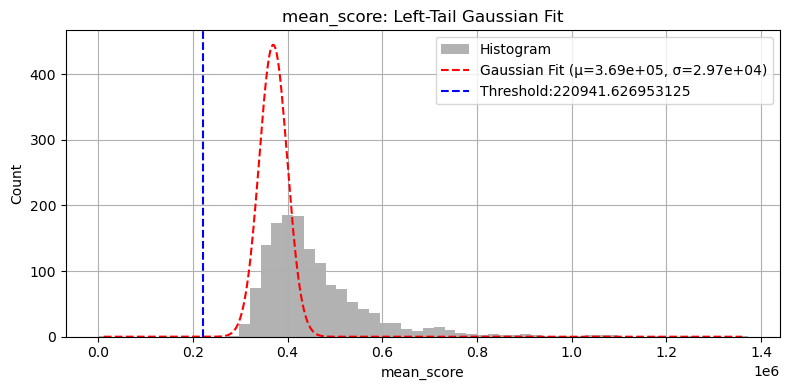

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Offset applied during final spike alignment
alignment_offset = 20

# Adjust selected spike indices
adjusted_selected_inds = selected_peaks[merged_clusters[best_idx]] - alignment_offset
adjusted_selected_inds = adjusted_selected_inds[
    (adjusted_selected_inds >= 0) & (adjusted_selected_inds < len(mean_score))
]

# Extract values
mean_score_prelim = mean_score[adjusted_selected_inds]
valid_score_prelim = valid_score[adjusted_selected_inds]

# --- Parameters ---
fit_percentile = 40
sigma_thresh = 5.0
bins = 60
feature_name = 'mean_score'

# --- Histogram ---
scores = mean_score_prelim.copy()
counts, bin_edges = np.histogram(scores, bins=bins, density=False)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

# --- Fit Gaussian to left tail ---
cutoff = np.percentile(scores, fit_percentile)
left_tail = scores[scores <= cutoff]
mu, sigma = norm.fit(left_tail)
mean_threshold = mu - sigma_thresh * sigma

# --- Gaussian for plotting ---
x_fit = np.linspace(min(bin_centers), max(bin_centers), 500)
y_fit = norm.pdf(x_fit, mu, sigma)
y_fit_scaled = y_fit * (len(scores) * (bin_edges[1] - bin_edges[0]))  # scale to histogram

# --- Plot ---
plt.figure(figsize=(8, 4))
plt.hist(scores, bins=bins, alpha=0.6, color='gray', label='Histogram')
plt.plot(x_fit, y_fit_scaled, 'r--', label=f'Gaussian Fit (μ={mu:.2e}, σ={sigma:.2e})')
plt.axvline(mean_threshold, color='blue', linestyle='--', label=f'Threshold:{mean_threshold}')
plt.title(f'{feature_name}: Left-Tail Gaussian Fit')
plt.xlabel(feature_name)
plt.ylabel('Count')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# threshold now stored in variable `mean_threshold`


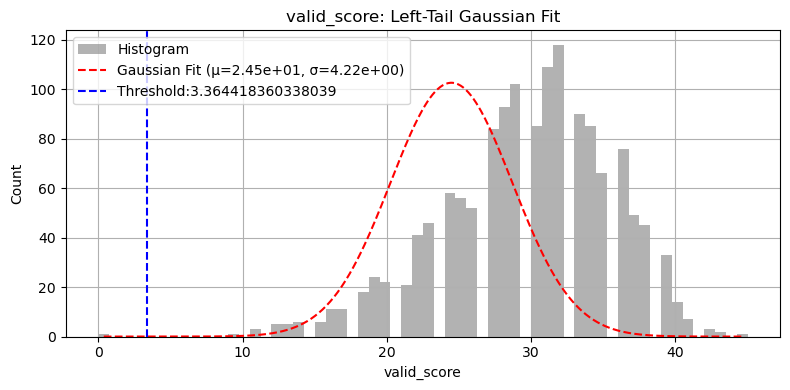

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Offset applied during final spike alignment
alignment_offset = 20

# Adjust selected spike indices
adjusted_selected_inds = selected_peaks[merged_clusters[best_idx]] - alignment_offset
adjusted_selected_inds = adjusted_selected_inds[
    (adjusted_selected_inds >= 0) & (adjusted_selected_inds < len(mean_score))
]

# Extract values
valid_score_prelim = valid_score[adjusted_selected_inds]

# --- Parameters ---
fit_percentile = 40
sigma_thresh = 5.0
bins = 60
feature_name = 'valid_score'

# --- Histogram ---
scores = valid_score_prelim.copy()
counts, bin_edges = np.histogram(scores, bins=bins, density=False)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

# --- Fit Gaussian to left tail ---
cutoff = np.percentile(scores, fit_percentile)
left_tail = scores[scores <= cutoff]
mu, sigma = norm.fit(left_tail)
valid_threshold = mu - sigma_thresh * sigma

# --- Gaussian for plotting ---
x_fit = np.linspace(min(bin_centers), max(bin_centers), 500)
y_fit = norm.pdf(x_fit, mu, sigma)
y_fit_scaled = y_fit * (len(scores) * (bin_edges[1] - bin_edges[0]))  # scale to histogram

# --- Plot ---
plt.figure(figsize=(8, 4))
plt.hist(scores, bins=bins, alpha=0.6, color='gray', label='Histogram')
plt.plot(x_fit, y_fit_scaled, 'r--', label=f'Gaussian Fit (μ={mu:.2e}, σ={sigma:.2e})')
plt.axvline(valid_threshold, color='blue', linestyle='--', label=f'Threshold:{valid_threshold}')
plt.title(f'{feature_name}: Left-Tail Gaussian Fit')
plt.xlabel(feature_name)
plt.ylabel('Count')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# threshold now stored in variable `valid_threshold`


### Step 8c: select candidate spikes

In [38]:
# --- Post-process scores into spike times ---
# Threshold based on mean or fixed value
peaks = argrelextrema(mean_score, np.greater_equal, order=1)[0]
valid_inds = peaks[(mean_score[peaks] > mean_threshold) & (valid_score[peaks] > valid_threshold)]

# --- Sanity check: limit number of accepted spikes ---
if len(valid_inds) > 50000:
    print(f"Too many spikes detected ({len(valid_inds)}), trimming to top 50,000.")
    top_inds = np.argsort(mean_score[valid_inds])[::-1][:50000]
    valid_inds = valid_inds[top_inds]

final_spike_times = valid_inds + 20  # aligns to center of window

print(f"Final spike count from EI pursuit: {len(final_spike_times)}")

Final spike count from EI pursuit: 1448


### Step 8d, optional: how many new spikes are added before final clustering?

In [41]:
# Step 9 prelude: compare final EI-pursuit events to original ones
original_events = selected_peaks[merged_clusters[best_idx]]  # absolute indices from Step 3
pursued_events = final_spike_times                        # from Step 8

# --- Create a fast lookup set for original spikes (with small tolerance) ---
original_set = set()
for t in original_events:
    original_set.update([t - 1, t, t + 1])  # ±2 tolerance

# --- Check which pursued events are new ---
new_spikes = [t for t in pursued_events if t not in original_set]
overlap_spikes = [t for t in pursued_events if t in original_set]

print(f"Total pursued: {len(pursued_events)}")
print(f"Original cluster: {len(original_events)}")
print(f"Overlap (already known): {len(overlap_spikes)}")
print(f"New spikes from EI pursuit: {len(new_spikes)}")


Total pursued: 1448
Original cluster: 1448
Overlap (already known): 1438
New spikes from EI pursuit: 10


### Step 9: Explicit re-clustering of final_spike_times

Selected 80 EI channels


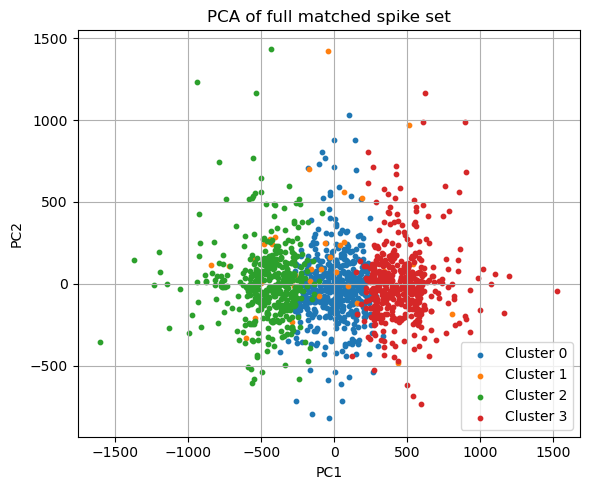

{0: 531, 1: 39, 2: 434, 3: 444}


In [30]:
import numpy as np
from extract_data_snippets import extract_snippets
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# --- Parameters ---
window = (-20, 60)
min_chan = 30
max_chan = 80
p2p_threshold = 15
k_clusters = 4

# --- Step 1: Extract snippets on full matched spike set ---
snips_full = extract_snippets(
    dat_path=dat_path,
    spike_times=final_spike_times,
    window=window,
    n_channels=512,
    dtype='int16'
)

# --- Step 2: Compute EI (mean + baseline correction) ---
ei_full = np.mean(snips_full, axis=2)
ei_full -= ei_full[:, :5].mean(axis=1, keepdims=True)

# --- Step 3: Select EI channels ---
ei_p2p = ei_full.max(axis=1) - ei_full.min(axis=1)
selected_channels = np.where(ei_p2p > p2p_threshold)[0]
if len(selected_channels) > max_chan:
    selected_channels = np.argsort(ei_p2p)[-max_chan:]
elif len(selected_channels) < min_chan:
    selected_channels = np.argsort(ei_p2p)[-min_chan:]
selected_channels = np.sort(selected_channels)
print(f"Selected {len(selected_channels)} EI channels")

# --- Step 4: Center + flatten snippets ---
snips_sel = snips_full[selected_channels, :, :]
snips_centered = snips_sel - snips_sel.mean(axis=1, keepdims=True)
flat = snips_centered.transpose(2, 0, 1).reshape(snips_sel.shape[2], -1)

# --- Step 5: PCA + KMeans ---
pcs = PCA(n_components=10).fit_transform(flat)
labels = KMeans(n_clusters=k_clusters, n_init=10, random_state=42).fit_predict(pcs)

# --- Plot PCA ---
plt.figure(figsize=(6, 5))
for k in np.unique(labels):
    plt.scatter(pcs[labels == k, 0], pcs[labels == k, 1], s=10, label=f"Cluster {k}")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA of full matched spike set")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Group spikes by cluster for later analysis ---
cluster_indices = {k: np.where(labels == k)[0] for k in np.unique(labels)}
print({k: len(v) for k, v in cluster_indices.items()})


### Step 9b: Compute Cluster EIs + Similarity Matrix

In [31]:
from compare_eis import compare_eis

cluster_eis = []
cluster_ids = sorted(cluster_indices.keys())

for k in cluster_ids:
    inds = cluster_indices[k]
    ei_k = np.mean(snips_full[:, :, inds], axis=2)
    ei_k -= ei_k[:, :5].mean(axis=1, keepdims=True)
    cluster_eis.append(ei_k)

# --- Similarity matrix ---
sim = compare_eis(cluster_eis)
print("Cluster EI similarity matrix:")
print(np.round(sim, 3))


Cluster EI similarity matrix:
[[1.    0.922 0.986 0.986]
 [0.922 1.    0.92  0.911]
 [0.986 0.92  1.    0.991]
 [0.986 0.911 0.991 1.   ]]


### Step 9c: Merge Similar Clusters

In [32]:
import networkx as nx
import numpy as np

similarity_threshold = 0.9
G = nx.Graph()
G.add_nodes_from(cluster_ids)

for i in range(len(cluster_ids)):
    for j in range(i + 1, len(cluster_ids)):
        if sim[i, j] >= similarity_threshold:
            G.add_edge(cluster_ids[i], cluster_ids[j])

merged_groups = list(nx.connected_components(G))
merged_clusters = []

print("Merged cluster groups:")
for group in merged_groups:
    group = sorted(list(group))
    print(f"  Group {group}")
    all_inds = np.concatenate([cluster_indices[i] for i in group])
    merged_clusters.append(np.sort(all_inds))

print(f"Final cluster count after merging: {len(merged_clusters)}")


Merged cluster groups:
  Group [0, 1, 2, 3]
Final cluster count after merging: 1


### Step 9d: Plot Merged Cluster EIs with Colors

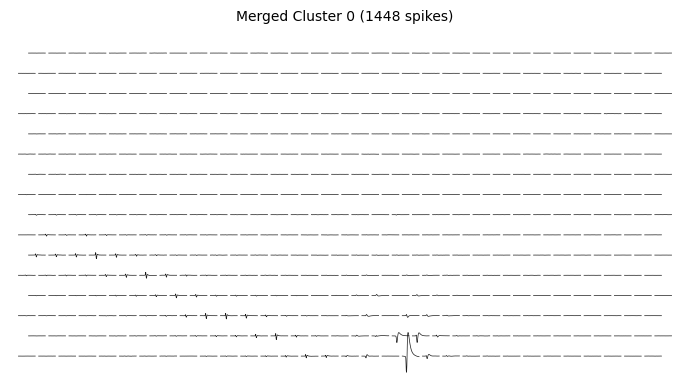

In [33]:
from plot_ei_waveforms import plot_ei_waveforms
import matplotlib.pyplot as plt

colors = ['black', 'red', 'blue', 'green', 'purple', 'orange', 'brown', 'teal', 'magenta', 'olive']
n_merged = len(merged_clusters)
n_cols = min(n_merged, 4)
n_rows = (n_merged + n_cols - 1) // n_cols

fig, axs = plt.subplots(n_rows, n_cols, figsize=(7 * n_cols, 7 * n_rows))
axs = axs.flatten() if n_merged > 1 else [axs]

for i, inds in enumerate(merged_clusters):
    ei_i = np.mean(snips_full[:, :, inds], axis=2)
    ei_i -= ei_i[:, :5].mean(axis=1, keepdims=True)
    color = colors[i % len(colors)]

    ax = axs[i]
    plot_ei_waveforms(
        ei=ei_i,
        positions=ei_positions,
        ax=ax,
        scale=70.0,
        box_height=1.0,   # can adjust for visibility
        box_width=50,
        linewidth=0.5,
        alpha=0.9,
        colors=color
    )
    ax.set_title(f"Merged Cluster {i} ({len(inds)} spikes)", fontsize=10)

for j in range(i+1, len(axs)):
    axs[j].axis('off')

plt.tight_layout()
plt.show()


### Step 9e: Find Most Similar Merged Cluster

In [ ]:
from compare_eis import compare_eis
import numpy as np

merged_eis = []

for inds in merged_clusters:
    ei = np.mean(snips_full[:, :, inds], axis=2)
    ei -= ei[:, :5].mean(axis=1, keepdims=True)
    merged_eis.append(ei)

similarities = compare_eis(merged_eis, ei_template=selected_ei).flatten()

best_idx = np.argmax(similarities)
print(f"Selected merged cluster: {best_idx}")
print(f"EI similarity to original: {similarities[best_idx]:.4f}")
print(f"Spike count: {len(merged_clusters[best_idx])}")

# Final output
final_spike_inds = merged_clusters[best_idx]
final_spike_times_cleaned = final_spike_times[final_spike_inds]

# Final spike times and snippets
spikes = final_spike_times[final_spike_inds]
snips = snips_full[:, :, final_spike_inds]

# Final EI
ei = np.mean(snips, axis=2)
ei -= ei[:, :5].mean(axis=1, keepdims=True)

# Select channels from final EI
ei_peak2peak = ei.max(axis=1) - ei.min(axis=1)
if np.sum(ei_peak2peak > p2p_threshold) >= 80:
    top = np.argsort(ei_peak2peak)[-80:]
    selected_channels = np.sort(top)
else:
    top = np.argsort(ei_peak2peak)[-30:]
    selected_channels = np.sort(top)



Selected merged cluster: 0
EI similarity to original: 1.0000
Spike count: 1448
[1982 2098 2386 2488 2739]
80


### Step 10: Export to HDF5

In [ ]:
import h5py

# --- Output file and unit name ---
h5_out_path = '/Volumes/Lab/Users/alexth/axolotl/results_pipeline_0527'  # path 2 save
unit_id = 0  # use unique ID per unit if repeating

with h5py.File(h5_out_path, 'a') as h5:
    group = h5.require_group(f'unit_{unit_id}')
    group.create_dataset('spike_times', data=spikes.astype(np.int32))
    group.create_dataset('ei_template', data=ei.astype(np.float32))
    group.create_dataset('selected_channels', data=selected_channels.astype(np.int32))
    group.attrs['peak_channel'] = int(np.argmax(np.ptp(ei, axis=1)))

print(f"Exported unit_{unit_id} with {len(spikes)} spikes.")


Exported unit_0 with 1448 spikes.


# Step 11: subtract templates from raw data file

In [36]:
# --- Assumes the following variables are defined in the notebook context ---
# final_spike_times_cleaned : spike times array
# selected_ei : EI array, shape (n_channels, n_samples)
# dat_path : path to .dat file
# ei_positions : array of shape (n_channels, 2)
# ref_channel : dominant/somatic channel
# start_sample, segment_length, dtype, n_channels, window, fit_offsets
import run_template_subtraction_on_channel
import importlib
importlib.reload(run_template_subtraction_on_channel)
from scipy.spatial import KDTree
import numpy as np

# --- Parameters ---
start_sample = 1700       # start of segment
segment_length = 200000        # number of samples
n_channels = 512
dtype = np.int16
window = (-20, 60)             # waveform window
fit_offsets = (-5, 10)

dat_path = '/Volumes/Lab/Users/alexth/axolotl/201703151_data001_sub.dat'


# --- Setup ---
ei = selected_ei
ei_p2p = ei.max(axis=1) - ei.min(axis=1)
selected_channels = np.where(ei_p2p > 15)[0]
selected_channels = selected_channels[np.argsort(ei_p2p[selected_channels])[::-1]]

# Build KDTree for neighbor queries
tree = KDTree(ei_positions)

# Precompute valid spikes (same for all channels)
valid_spikes = [s for s in final_spike_times_cleaned
                if (s + window[0] >= start_sample) and (s + window[1] < start_sample + segment_length)]
valid_spikes = np.array(valid_spikes)

# Initialize storage for fit parameters
all_channel_fit_params = {ch: None for ch in selected_channels}

# Run for each channel in order
for ch_idx in selected_channels:
    print(f"\n--- Processing channel {ch_idx} ---")

    # Find already-processed neighbor channels (within radius or nearest N)
    ch_coord = ei_positions[ch_idx]
    neighbor_dists, neighbor_idxs = tree.query(ch_coord, k=6)
    neighbor_idxs = neighbor_idxs[neighbor_dists > 0]  # exclude self if present
    valid_neighbors = [idx for idx in neighbor_idxs if idx in all_channel_fit_params and all_channel_fit_params[idx] is not None]


    # Gather per-spike fallback parameters from valid neighbors
    if len(valid_neighbors) == 0:
        fallback_params = None
    else:
        fallback_params = {}
        for i, spike_time in enumerate(valid_spikes):
            per_spike_vals = [all_channel_fit_params[idx][i] for idx in valid_neighbors]
            fallback_params[spike_time] = np.mean(per_spike_vals, axis=0)

    # Run subtraction and accumulate results
    channel_params = run_template_subtraction_on_channel.run_template_subtraction_on_channel(
        channel_idx=ch_idx,
        final_spike_times=final_spike_times_cleaned,
        ei_waveform=selected_ei[ch_idx],
        dat_path=dat_path,
        start_sample=start_sample,
        segment_length=segment_length,
        dtype=dtype,
        n_channels=n_channels,
        window=window,
        fit_offsets=fit_offsets,
        fallback_fit_params=fallback_params,
        diagnostic_plot_spikes=None #valid_spikes[:2]
    )
    all_channel_fit_params[ch_idx] = channel_params




--- Processing channel 39 ---

--- Processing channel 43 ---


KeyboardInterrupt: 

### Miscellaneous: test template fitting

In [ ]:
# --- Assumes the following variables are defined in the notebook context ---
# final_spike_times_cleaned : spike times array
# selected_ei : EI array, shape (n_channels, n_samples)
# dat_path : path to .dat file
# ei_positions : array of shape (n_channels, 2)
# ref_channel : dominant/somatic channel
# start_sample, segment_length, dtype, n_channels, window, fit_offsets
import run_template_subtraction_on_channel
import importlib
importlib.reload(run_template_subtraction_on_channel)
from scipy.spatial import KDTree
import numpy as np

# --- Parameters ---
start_sample = 0       # start of segment
segment_length = 20000        # number of samples
n_channels = 512
dtype = np.int16
window = (-20, 60)             # waveform window
fit_offsets = (-5, 10)

dat_path = '/Volumes/Lab/Users/alexth/axolotl/201703151_data001_sub.dat'

spikes = spikes[:5]

# Precompute valid spikes (for fallback and range checks)
valid_spikes = [s for s in spikes if (s + window[0] >= 0) and (s + window[1] < total_samples)]
valid_spikes = np.array(valid_spikes)

selected_channels = [39]

    channel_params = run_template_subtraction_on_channel.run_template_subtraction_on_channel(
        channel_idx=39,
        final_spike_times=spikes,
        ei_waveform=selected_ei[ch_idx],
        dat_path=dat_path,
        start_sample=start_sample,
        segment_length=segment_length,
        dtype=dtype,
        n_channels=n_channels,
        window=window,
        fit_offsets=fit_offsets,
        fallback_fit_params=None,
        diagnostic_plot_spikes=valid_spikes[:2]
    )

    
# Run for each channel in order
for ch_idx in selected_channels:
    print(f"\n--- Processing channel {ch_idx} ---")

    # Find already-processed neighbor channels (within radius or nearest N)
    ch_coord = ei_positions[ch_idx]
    neighbor_dists, neighbor_idxs = tree.query(ch_coord, k=6)
    neighbor_idxs = neighbor_idxs[neighbor_dists > 0]  # exclude self if present
    valid_neighbors = [idx for idx in neighbor_idxs if idx in all_channel_fit_params and all_channel_fit_params[idx] is not None]


    # Gather per-spike fallback parameters from valid neighbors
    if len(valid_neighbors) == 0:
        fallback_params = None
    else:
        fallback_params = {}
        for i, spike_time in enumerate(valid_spikes):
            per_spike_vals = [all_channel_fit_params[idx][i] for idx in valid_neighbors]
            fallback_params[spike_time] = np.mean(per_spike_vals, axis=0)

    # Run subtraction and accumulate results
    channel_params = run_template_subtraction_on_channel.run_template_subtraction_on_channel(
        channel_idx=ch_idx,
        final_spike_times=final_spike_times_cleaned,
        ei_waveform=selected_ei[ch_idx],
        dat_path=dat_path,
        start_sample=start_sample,
        segment_length=segment_length,
        dtype=dtype,
        n_channels=n_channels,
        window=window,
        fit_offsets=fit_offsets,
        fallback_fit_params=fallback_params,
        diagnostic_plot_spikes=None #valid_spikes[:2]
    )
    all_channel_fit_params[ch_idx] = channel_params



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.interpolate import interp1d

# --- Parameters ---
ref_channel = 35          # replace with dominant channel from Step 1
n_spikes_to_test = 5
window = (-20, 60)         # 81 samples
snip_len = window[1] - window[0] + 1
dtype = np.int16
n_channels = 512
ei_template=selected_ei
fit_offsets = (-5, 10)  # relative to peak
dat_path = '/Volumes/Lab/Users/alexth/axolotl/201703151_data001.dat'

# --- Step 1: Extract spike waveforms for test subset ---
spike_subset = final_spike_times_cleaned[:n_spikes_to_test]
snips_test = np.zeros((snip_len, n_spikes_to_test), dtype=np.float32)

with open(dat_path, 'rb') as f:
    for i, center in enumerate(spike_subset):
        t_start = center + window[0]
        t_end = center + window[1]
        offset = t_start * n_channels * np.dtype(dtype).itemsize
        f.seek(offset)
        raw = np.fromfile(f, dtype=dtype, count=n_channels * snip_len)
        segment = raw.reshape((snip_len, n_channels)).T
        snips_test[:, i] = segment[ref_channel]

# --- Step 2: Extract and baseline-correct template ---
template = ei_template[ref_channel].copy()
template -= np.mean(template[:5])
t_template = np.arange(len(template))  # <- sample index domain
t_peak_template = np.argmin(template)  # fixed anchor for all spikes


# --- Step 3: Define fitting function ---

def fit_error(params, spike, t_peak):
    A, w, b, delta = params

    t = np.arange(len(spike))
    t_shifted = (t - t_peak - delta) / w + t_peak
    interp_func = interp1d(t_template, template, kind='cubic',
                           fill_value="extrapolate", bounds_error=False)
    warped_template = interp_func(t_shifted)
    #warped_template = np.pad(warped_template, (0, len(spike) - len(warped_template)), mode='edge')

    t0 = max(t_peak + fit_offsets[0], 0)
    t1 = min(t_peak + fit_offsets[1], len(spike) - 1)

    spike_cut = spike[t0:t1 + 1]
    warped_cut = warped_template[t0:t1 + 1]

    return np.sum((spike_cut - (A * warped_cut + b)) ** 2)




# --- Step 4: Fit and plot for each spike ---

for i in range(n_spikes_to_test):
    spike = snips_test[:, i].copy()
    spike -= np.mean(spike[:5])  # baseline correction

    t_peak = t_peak_template

    # --- Fit amplitude + width + offset ---
    res = minimize(
        fun=fit_error,
        x0=[1.0, 1.0, 0.0, 0.0],
        args=(spike, t_peak_template),
        bounds=[
            (0.75, 1.25),  # A
            (0.9, 1.1),    # w
            (-500, 500),   # b
            (-1.0, 1.0)    # delta
        ]
    )

    A_fit, w_fit, b_fit, delta_fit = res.x

    # --- Generate warped + shifted template ---
    t = np.arange(len(spike))
    t_shifted = (t - t_peak - delta_fit) / w_fit + t_peak
    t_shifted_clipped = np.clip(t_shifted, 0, len(template) - 1)


    interp_func = interp1d(t_template, template, kind='cubic', bounds_error=False)
    warped_template = interp_func(t_shifted_clipped)

    template_amp_width = A_fit * warped_template + b_fit

    # --- Amplitude-only fit (no warp, no shift, no offset) ---
    A_only = np.dot(spike, template) / np.dot(template, template)
    template_amp_only = A_only * template

    # --- Residual trace (no offset for subtraction) ---
    residual = spike - A_fit * warped_template

    # --- Fit error window (same as fit_error)
    t0 = max(t_peak + fit_offsets[0], 0)
    t1 = min(t_peak + fit_offsets[1], len(spike) - 1)

    spike_cut = spike[t0:t1 + 1]
    template_cut = A_fit * warped_template[t0:t1 + 1]  # no offset
    residual_cut = spike_cut - template_cut

    template_cut_amp_only = template[t0:t1 + 1]
    template_cut_fitted = A_fit * warped_template[t0:t1 + 1]

    residual_amp_only = spike_cut - template_cut_amp_only
    residual_fitted = spike_cut - template_cut_fitted

    rms_amp_only = np.sqrt(np.mean(residual_amp_only**2))
    rms_fitted = np.sqrt(np.mean(residual_fitted**2))

    rms_improvement = (rms_amp_only - rms_fitted) / rms_amp_only

    if rms_improvement < 0.10:
        # Reject fit, use amplitude-only
        A_fit = A_only
        w_fit = 1.0
        b_fit = 0.0
        delta_fit = 0.0
        used_fallback = True
    else:
        used_fallback = False





    # --- Plot all ---
    t = np.arange(len(spike))
    plt.figure(figsize=(8, 4))
    plt.plot(t, spike, label='Raw Spike', color='black')
    plt.plot(t, template, label='EI Template', linestyle='--', color='gray')
    plt.plot(t, template_amp_width, label='Full Fit', color='red')
    plt.plot(t, residual, label='Subtracted Residual', color='green')
    plt.axvline(t_peak, color='k', linestyle=':', alpha=0.5)
    plt.title(
    f"Spike {i+1}: A={A_fit:.2f}, w={w_fit:.3f}, b={b_fit:.1f}, delta={delta_fit:.1f}, "
    f"RMS_fit={rms_fitted:.1f}, RMS_raw={rms_amp_only:.1f}"
    )

    plt.xlabel("Sample")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()



### Loop through channels to fit templates, starting from the largest, and using other channels if needed

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.interpolate import interp1d
from scipy.spatial.distance import cdist

# --- Parameters ---
window = (-20, 60)
snip_len = window[1] - window[0] + 1
fit_offsets = (-5, 10)
rms_thresh = 0.10  # fractional improvement
n_spikes = 5
dtype = np.int16
n_channels = 512

# --- Inputs (assumed to be defined) ---
# final_spike_times_cleaned, selected_ei, ei_positions, dat_path

ei = selected_ei
ei_p2p = ei.max(axis=1) - ei.min(axis=1)
selected_channels = np.where(ei_p2p > 15)[0]
selected_channels = selected_channels[np.argsort(ei_p2p[selected_channels])[::-1]]

spike_subset = final_spike_times_cleaned[:n_spikes]
pos = ei_positions[selected_channels]
dists = cdist(pos, pos)
neighbor_map = {i: np.argsort(dists[i])[1:4] for i in range(len(selected_channels))}

snips = np.zeros((len(selected_channels), snip_len, n_spikes), dtype=np.float32)
with open(dat_path, 'rb') as f:
    for i, center in enumerate(spike_subset):
        offset = (center + window[0]) * n_channels * np.dtype(dtype).itemsize
        f.seek(offset)
        raw = np.fromfile(f, dtype=dtype, count=n_channels * snip_len)
        segment = raw.reshape((snip_len, n_channels)).T
        for j, chan in enumerate(selected_channels):
            trace = segment[chan].astype(np.float32)
            trace -= np.mean(trace[:5])
            snips[j, :, i] = trace

fit_results = {}
template_time = np.arange(ei.shape[1])
fig, axs = plt.subplots(len(selected_channels), n_spikes, figsize=(3.5*n_spikes, 2.8*len(selected_channels)))

for chan_idx, chan in enumerate(selected_channels):
    template = ei[chan].copy()
    template -= np.mean(template[:5])
    t_peak = np.argmin(template)

    for spike_idx in range(n_spikes):
        spike = snips[chan_idx, :, spike_idx].copy()
        t = np.arange(len(spike))

        def fit_error(params):
            A, w, b, delta = params
            t_shifted = (t - t_peak - delta) / w + t_peak
            t_shifted = np.clip(t_shifted, 0, len(template) - 1)
            interp_func = interp1d(template_time, template, kind='cubic', bounds_error=False)
            warped = interp_func(t_shifted)
            return np.sum((spike[t0:t1+1] - (A * warped[t0:t1+1] + b)) ** 2)

        t0 = max(t_peak + fit_offsets[0], 0)
        t1 = min(t_peak + fit_offsets[1], snip_len - 1)

        # Amplitude-only template match (baseline RMS)
        A_only = np.dot(spike, template) / np.dot(template, template)
        template_amp_only = A_only * template
        residual_raw_cut = spike[t0:t1+1] - template_amp_only[t0:t1+1]
        rms_raw = np.sqrt(np.mean(residual_raw_cut**2))

        # Full fit
        res = minimize(fit_error, x0=[1.0, 1.0, 0.0, 0.0],
                       bounds=[(0.75, 1.25), (0.9, 1.1), (-500, 500), (-1.0, 1.0)])
        A_fit, w_fit, b_fit, delta_fit = res.x
        rms_init = np.sqrt(res.fun / (t1 - t0 + 1))

        # Build warped template
        t_shifted = (t - t_peak - delta_fit) / w_fit + t_peak
        t_shifted = np.clip(t_shifted, 0, len(template) - 1)
        interp_func = interp1d(template_time, template, kind='cubic', bounds_error=False)
        warped = interp_func(t_shifted)
        template_fit = A_fit * warped + b_fit
        residual_cut = spike[t0:t1+1] - template_fit[t0:t1+1]
        rms_fit = np.sqrt(np.mean(residual_cut**2))

        rms_improvement = (rms_raw - rms_fit) / rms_raw
        used_neighbors = []

        # Fallback if RMS improvement too low
        if rms_improvement < rms_thresh and chan_idx != 0:
            for neighbor_rank in neighbor_map[chan_idx]:
                if (neighbor_rank, spike_idx) in fit_results:
                    A_fit, w_fit, b_fit, delta_fit = fit_results[(neighbor_rank, spike_idx)]['params']
                    used_neighbors.append(selected_channels[neighbor_rank])
                    break
            if used_neighbors:
                t_shifted = (t - t_peak - delta_fit) / w_fit + t_peak
                t_shifted = np.clip(t_shifted, 0, len(template) - 1)
                warped = interp_func(t_shifted)
                template_fit = A_fit * warped + b_fit
                residual_cut = spike[t0:t1+1] - template_fit[t0:t1+1]
                rms_fit = np.sqrt(np.mean(residual_cut**2))

        fit_results[(chan_idx, spike_idx)] = {
            'params': (A_fit, w_fit, b_fit, delta_fit),
            'rms_fit': rms_fit,
            'rms_raw': rms_raw,
            'used_neighbors': used_neighbors
        }

        # Plotting
        ax = axs[chan_idx, spike_idx] if len(selected_channels) > 1 else axs[spike_idx]
        ax.plot(spike, label='Raw', color='black')
        ax.plot(template, label='Template', linestyle='--', color='gray')
        ax.plot(template_fit, label='Full Fit', color='red')
        residual_full = spike - (A_fit * warped)  # just for full trace display
        ax.plot(residual_full, label='Residual', color='green')
        ax.axvline(t_peak, linestyle=':', color='gray')
        ax.set_title(
            f"Chan {selected_channels[chan_idx]}, Spike {spike_idx+1}\n"
            f"RMS_init={rms_init:.1f}, RMS_final={rms_fit:.1f}\n"
            f"neighbors={used_neighbors}"
        )
        ax.set_xticks([])
        ax.set_yticks([])

plt.tight_layout()
plt.legend(loc='upper right', bbox_to_anchor=(1.05, 1.0))
plt.show()


### subtraction test on 1 channel, small segment of raw data

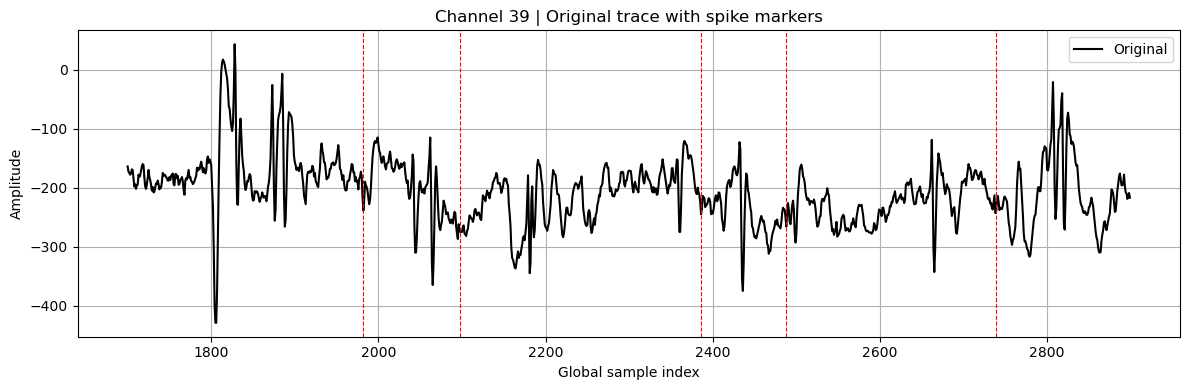

In [226]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.interpolate import interp1d

# --- Parameters ---
ref_channel = 39
start_sample = 1700       # start of segment
segment_length = 1200        # number of samples
n_channels = 512
dtype = np.int16
window = (-20, 60)             # waveform window
fit_offsets = (-5, 10)

dat_path = '/Volumes/Lab/Users/alexth/axolotl/201703151_data001_sub.dat'

ei_trace = selected_ei[ref_channel].copy()
ei_trace -= np.mean(ei_trace[:5])
t_template = np.arange(len(ei_trace))
t_peak_template = np.argmin(ei_trace)



# --- Step 1: Read unmodified segment ---
segment_offset_bytes = start_sample * n_channels * np.dtype(dtype).itemsize
segment_shape = (segment_length, n_channels)

with open(dat_path, 'rb') as f:
    f.seek(0, 2)
    file_len_bytes = f.tell()
n_total_samples = file_len_bytes // (np.dtype(dtype).itemsize * n_channels)
assert start_sample + segment_length <= n_total_samples, "Segment overflows file."

raw_mem = np.memmap(dat_path, dtype=dtype, mode='r', offset=segment_offset_bytes, shape=segment_shape)
raw_trace_original = raw_mem[:, ref_channel].astype(np.float32).copy()

# --- Step 2: Select spikes that fall fully within the segment + window margin ---
valid_spikes = []
for s in final_spike_times_cleaned:
    if (s + window[0] >= start_sample) and (s + window[1] < start_sample + segment_length):
        valid_spikes.append(s)
valid_spikes = np.array(valid_spikes)

t_global = np.arange(start_sample, start_sample + segment_length)

plt.figure(figsize=(12, 4))
plt.plot(t_global, raw_trace_original, label="Original", color='black')

for s in valid_spikes:
    plt.axvline(s, color='red', linestyle='--', linewidth=0.8)

plt.title(f"Channel {ref_channel} | Original trace with spike markers")
plt.xlabel("Global sample index")
plt.ylabel("Amplitude")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



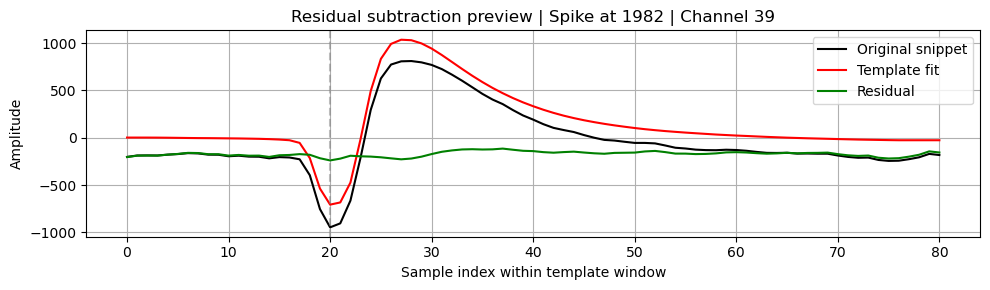

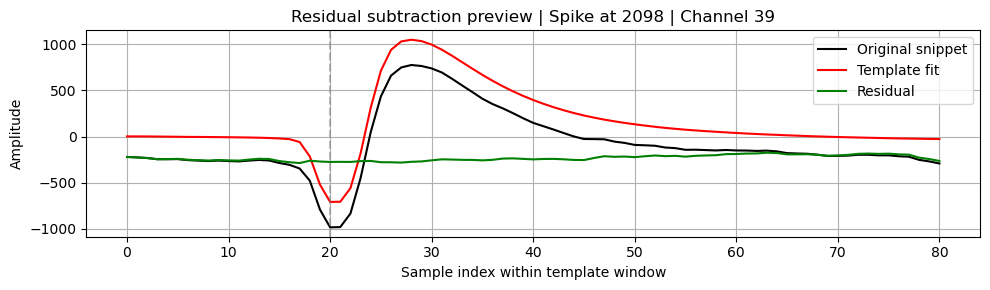

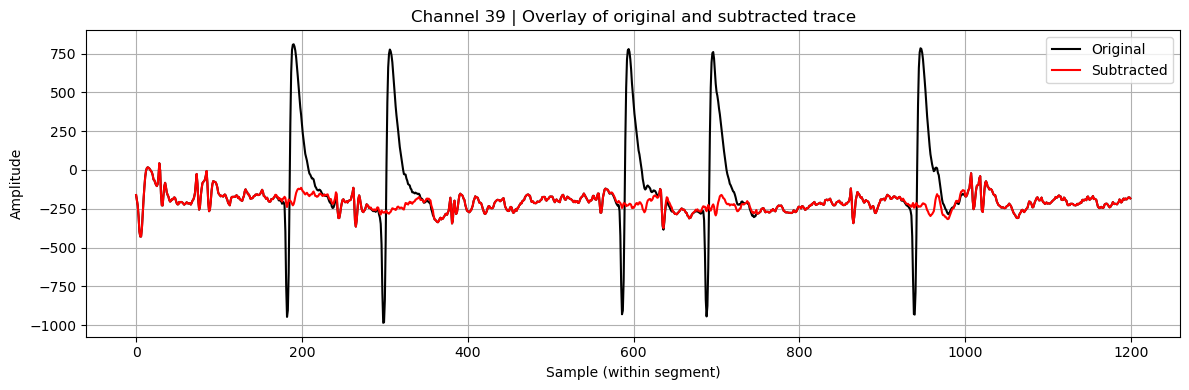

In [220]:
from scipy.optimize import minimize
from scipy.interpolate import interp1d

# --- Step 3: Open full raw data for editing ---
raw_edit = np.memmap(dat_path, dtype=dtype, mode='r+', shape=(n_total_samples, n_channels))

# --- Step 4: Loop over valid spikes and subtract template ---
for s in valid_spikes:
    t_start = s + window[0]
    t_end = s + window[1]
    snip_len = t_end - t_start + 1

    if t_start < 0 or t_end >= n_total_samples:
        continue  # skip out-of-bounds spikes

    snippet = raw_edit[t_start:t_end + 1, ref_channel].astype(np.float32)
    snippet -= np.mean(snippet[:5])
    t = np.arange(snip_len)

    t0 = max(t_peak_template + fit_offsets[0], 0)
    t1 = min(t_peak_template + fit_offsets[1], snip_len - 1)

    # --- Amplitude-only baseline fit ---
    A_only = np.dot(snippet, ei_trace) / np.dot(ei_trace, ei_trace)
    template_amp_only = A_only * ei_trace
    rms_raw = np.sqrt(np.mean((snippet[t0:t1 + 1] - template_amp_only[t0:t1 + 1]) ** 2))

    # --- Fit error function ---
    def fit_error(params):
        A, w, b, delta = params
        t_shifted = (t - t_peak_template - delta) / w + t_peak_template
        t_shifted = np.clip(t_shifted, 0, len(ei_trace) - 1)
        warped = interp1d(t_template, ei_trace, kind='cubic', bounds_error=False)(t_shifted)
        return np.sum((snippet[t0:t1 + 1] - (A * warped[t0:t1 + 1] + b)) ** 2)

    # --- Optimize parameters ---
    res = minimize(fit_error, x0=[1.0, 1.0, 0.0, 0.0],
                   bounds=[(0.75, 1.25), (0.9, 1.1), (-500, 500), (-1.0, 1.0)])
    A_fit, w_fit, b_fit, delta_fit = res.x
    rms_fit = np.sqrt(res.fun / (t1 - t0 + 1))

    rms_improvement = (rms_raw - rms_fit) / rms_raw

    if rms_improvement < 0.1:
        # fallback: amplitude-only
        A_fit = A_only
        w_fit = 1.0
        b_fit = 0.0
        delta_fit = 0.0
        template_fit = A_fit * ei_trace
    else:
        # warp the full template using fit
        t_shifted = (t - t_peak_template - delta_fit) / w_fit + t_peak_template
        t_shifted = np.clip(t_shifted, 0, len(ei_trace) - 1)
        warped = interp1d(t_template, ei_trace, kind='cubic', bounds_error=False)(t_shifted)
        template_fit = A_fit * warped  # DO NOT include b_fit in subtraction

    raw_snip = raw_edit[t_start:t_end+1, ref_channel].astype(np.float32)

        # --- Diagnostic plot of residual before writing ---
    if 0 and s == valid_spikes[0] or s == valid_spikes[1]:  # limit to a couple spikes for clarity
        residual = raw_snip - template_fit
        plt.figure(figsize=(10, 3))
        plt.plot(raw_snip, label='Original snippet', color='black')
        plt.plot(template_fit, label='Template fit', color='red')
        plt.plot(residual, label='Residual', color='green')
        plt.axvline(t_peak_template, linestyle='--', color='gray', alpha=0.5)
        plt.title(f"Residual subtraction preview | Spike at {s} | Channel {ref_channel}")
        plt.xlabel("Sample index within template window")
        plt.ylabel("Amplitude")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    raw_edit[t_start:t_end+1, ref_channel] = np.clip(
        raw_snip - template_fit, -32768, 32767
    ).astype(dtype)

segment_offset_bytes = start_sample * n_channels * np.dtype(dtype).itemsize
raw_after = np.memmap(dat_path, dtype=dtype, mode='r', offset=segment_offset_bytes, shape=segment_shape)
raw_trace_after = raw_after[:, ref_channel].astype(np.float32)


plt.figure(figsize=(12, 4))
plt.plot(np.arange(segment_length), raw_trace_original, label="Original", color='black')
plt.plot(np.arange(segment_length), raw_trace_after, label="Subtracted", color='red')
plt.title(f"Channel {ref_channel} | Overlay of original and subtracted trace")
plt.xlabel("Sample (within segment)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [166]:
print(final_spike_times_cleaned[:5])

[1982 2098 2386 2488 2739]


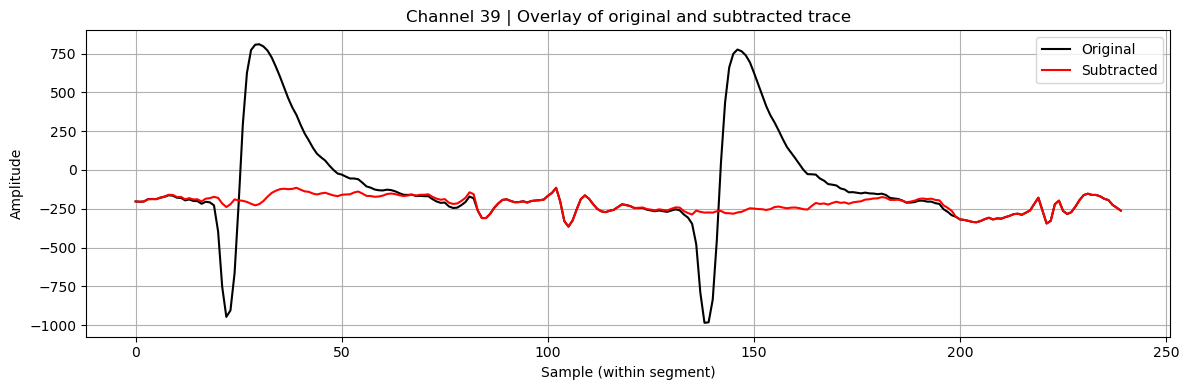

In [221]:
plt.figure(figsize=(12, 4))
plt.plot(raw_trace_original[160:400], label="Original", color='black')
plt.plot(raw_trace_after[160:400], label="Subtracted", color='red')
plt.title(f"Channel {ref_channel} | Overlay of original and subtracted trace")
plt.xlabel("Sample (within segment)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


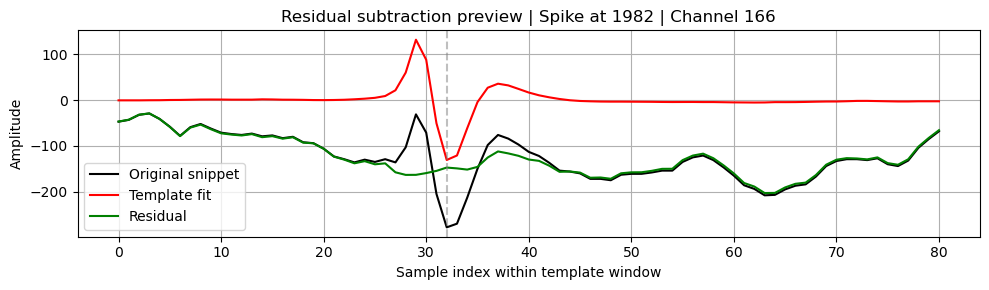

2488
47231
52151
89122
167047


In [232]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.interpolate import interp1d


A_vals = []
w_vals = []
delta_vals = []


# --- Parameters ---
ref_channel = 166
start_sample = 1700       # start of segment
segment_length = 200000        # number of samples
n_channels = 512
dtype = np.int16
window = (-20, 60)             # waveform window
fit_offsets = (-5, 10)

dat_path = '/Volumes/Lab/Users/alexth/axolotl/201703151_data001_sub.dat'

ei_trace = selected_ei[ref_channel].copy()
ei_trace -= np.mean(ei_trace[:5])
t_template = np.arange(len(ei_trace))
t_peak_template = np.argmin(ei_trace)



# --- Step 1: Read unmodified segment ---
segment_offset_bytes = start_sample * n_channels * np.dtype(dtype).itemsize
segment_shape = (segment_length, n_channels)

with open(dat_path, 'rb') as f:
    f.seek(0, 2)
    file_len_bytes = f.tell()
n_total_samples = file_len_bytes // (np.dtype(dtype).itemsize * n_channels)
assert start_sample + segment_length <= n_total_samples, "Segment overflows file."

raw_mem = np.memmap(dat_path, dtype=dtype, mode='r', offset=segment_offset_bytes, shape=segment_shape)
raw_trace_original = raw_mem[:, ref_channel].astype(np.float32).copy()

# --- Step 2: Select spikes that fall fully within the segment + window margin ---
valid_spikes = []
for s in final_spike_times_cleaned:
    if (s + window[0] >= start_sample) and (s + window[1] < start_sample + segment_length):
        valid_spikes.append(s)
valid_spikes = np.array(valid_spikes)

t_global = np.arange(start_sample, start_sample + segment_length)



# --- Step 3: Open full raw data for editing ---
raw_edit = np.memmap(dat_path, dtype=dtype, mode='r+', shape=(n_total_samples, n_channels))

# --- Step 4: Loop over valid spikes and subtract template ---
for s in valid_spikes:
    t_start = s + window[0]
    t_end = s + window[1]
    snip_len = t_end - t_start + 1

    if t_start < 0 or t_end >= n_total_samples:
        continue  # skip out-of-bounds spikes

    snippet = raw_edit[t_start:t_end + 1, ref_channel].astype(np.float32)
    snippet -= np.mean(snippet[:5])
    t = np.arange(snip_len)

    t0 = max(t_peak_template + fit_offsets[0], 0)
    t1 = min(t_peak_template + fit_offsets[1], snip_len - 1)

    # --- Amplitude-only baseline fit ---
    A_only = np.dot(snippet, ei_trace) / np.dot(ei_trace, ei_trace)
    template_amp_only = A_only * ei_trace
    rms_raw = np.sqrt(np.mean((snippet[t0:t1 + 1] - template_amp_only[t0:t1 + 1]) ** 2))

    # --- Fit error function ---
    def fit_error(params):
        A, w, b, delta = params
        t_shifted = (t - t_peak_template - delta) / w + t_peak_template
        t_shifted = np.clip(t_shifted, 0, len(ei_trace) - 1)
        warped = interp1d(t_template, ei_trace, kind='cubic', bounds_error=False)(t_shifted)
        return np.sum((snippet[t0:t1 + 1] - (A * warped[t0:t1 + 1] + b)) ** 2)

    # --- Optimize parameters ---
    res = minimize(fit_error, x0=[1.0, 1.0, 0.0, 0.0],
                   bounds=[(0.75, 1.25), (0.9, 1.1), (-500, 500), (-1.0, 1.0)])
    A_fit, w_fit, b_fit, delta_fit = res.x
    rms_fit = np.sqrt(res.fun / (t1 - t0 + 1))

    rms_improvement = (rms_raw - rms_fit) / rms_raw

    if rms_improvement < 0.1:
        print(s)
        # fallback: amplitude-only
        A_fit = A_only
        w_fit = 1.0
        b_fit = 0.0
        delta_fit = 0.0
        template_fit = A_fit * ei_trace
    else:
        # warp the full template using fit
        t_shifted = (t - t_peak_template - delta_fit) / w_fit + t_peak_template
        t_shifted = np.clip(t_shifted, 0, len(ei_trace) - 1)
        warped = interp1d(t_template, ei_trace, kind='cubic', bounds_error=False)(t_shifted)
        template_fit = A_fit * warped  # DO NOT include b_fit in subtraction

    A_vals.append(A_fit)
    w_vals.append(w_fit)
    delta_vals.append(delta_fit)


    raw_snip = raw_edit[t_start:t_end+1, ref_channel].astype(np.float32)

        # --- Diagnostic plot of residual before writing ---
    if s == valid_spikes[0]:  # limit to a couple spikes for clarity
        residual = raw_snip - template_fit
        plt.figure(figsize=(10, 3))
        plt.plot(raw_snip, label='Original snippet', color='black')
        plt.plot(template_fit, label='Template fit', color='red')
        plt.plot(residual, label='Residual', color='green')
        plt.axvline(t_peak_template, linestyle='--', color='gray', alpha=0.5)
        plt.title(f"Residual subtraction preview | Spike at {s} | Channel {ref_channel}")
        plt.xlabel("Sample index within template window")
        plt.ylabel("Amplitude")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
        
    #raw_edit[t_start:t_end+1, ref_channel] = np.clip(
    #    raw_snip - template_fit, -32768, 32767
    #).astype(dtype)


A_vals = np.array(A_vals)
w_vals = np.array(w_vals)
delta_vals = np.array(delta_vals)




### examine parameters

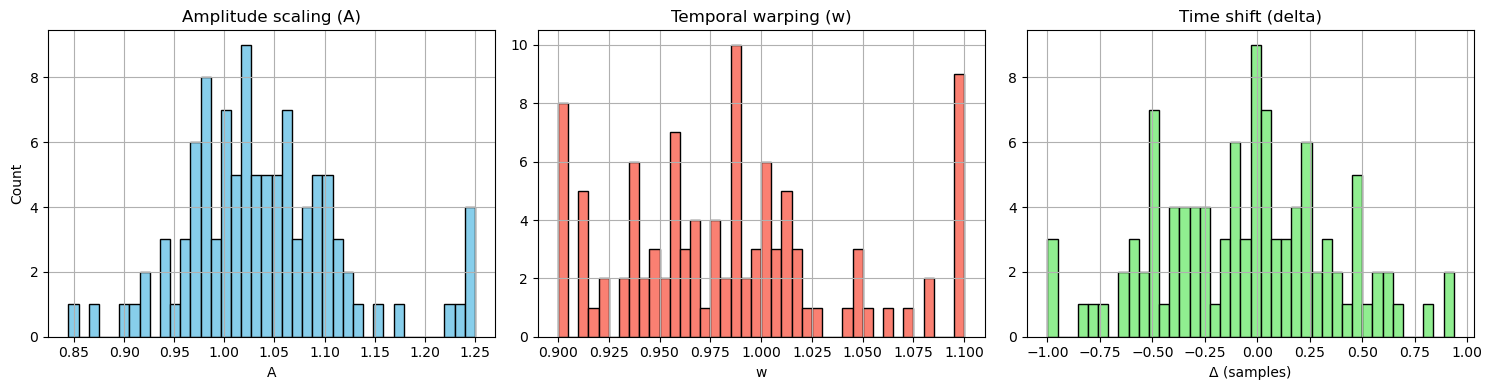

In [233]:
import matplotlib.pyplot as plt

# --- After loop ends ---

# Convert to NumPy arrays (if not already)
A_vals = np.array(A_vals)
w_vals = np.array(w_vals)
delta_vals = np.array(delta_vals)

# --- Plot histograms ---
fig, axs = plt.subplots(1, 3, figsize=(15, 4))

axs[0].hist(A_vals, bins=40, color='skyblue', edgecolor='k')
axs[0].set_title("Amplitude scaling (A)")
axs[0].set_xlabel("A")
axs[0].set_ylabel("Count")
axs[0].grid(True)

axs[1].hist(w_vals, bins=40, color='salmon', edgecolor='k')
axs[1].set_title("Temporal warping (w)")
axs[1].set_xlabel("w")
axs[1].grid(True)

axs[2].hist(delta_vals, bins=40, color='lightgreen', edgecolor='k')
axs[2].set_title("Time shift (delta)")
axs[2].set_xlabel("Δ (samples)")
axs[2].grid(True)

plt.tight_layout()
plt.show()


### edit file in the loop over channels

In [234]:
# Compute order of channels by peak to peak amplitude (descending)
ei = selected_ei
ei_p2p = ei.max(axis=1) - ei.min(axis=1)
selected_channels = np.where(ei_p2p > 15)[0]
channel_order = selected_channels[np.argsort(ei_p2p[selected_channels])[::-1]]
print(channel_order)

[ 39  43  35  91 171 166 110 118  31 159 102 172  79  99 170 165  55 167
 168  38 169 122 126  71 164 179  83 177  27 158  94  54 173  30  87 107
  50 125  34  63 115 157 114 163 106  59 180 174  95 162  51 151  86 184
 156 178  23 123  98  58  26 160 117 161  75  22 185  40 103 186  19 150
  90 143 182  62  37  53 155  78 109  29 111 121 187 119 175 101  82 183
 181 142 149 154 192  93  61  18 113  15  66 188 153  14 152]


In [ ]:
# --- Assumes the following variables are defined in the notebook context ---
# final_spike_times_cleaned : spike times array
# selected_ei : EI array, shape (n_channels, n_samples)
# dat_path : path to .dat file
# ei_positions : array of shape (n_channels, 2)
# ref_channel : dominant/somatic channel
# start_sample, segment_length, dtype, n_channels, window, fit_offsets
import run_template_subtraction_on_channel
import importlib
importlib.reload(run_template_subtraction_on_channel)
from scipy.spatial import KDTree
import numpy as np

# --- Parameters ---
start_sample = 1700       # start of segment
segment_length = 200000        # number of samples
n_channels = 512
dtype = np.int16
window = (-20, 60)             # waveform window
fit_offsets = (-5, 10)

dat_path = '/Volumes/Lab/Users/alexth/axolotl/201703151_data001_sub.dat'


# --- Setup ---
ei = selected_ei
ei_p2p = ei.max(axis=1) - ei.min(axis=1)
selected_channels = np.where(ei_p2p > 15)[0]
selected_channels = selected_channels[np.argsort(ei_p2p[selected_channels])[::-1]]

# Build KDTree for neighbor queries
tree = KDTree(ei_positions)

# Precompute valid spikes (same for all channels)
valid_spikes = [s for s in final_spike_times_cleaned
                if (s + window[0] >= start_sample) and (s + window[1] < start_sample + segment_length)]
valid_spikes = np.array(valid_spikes)

# Initialize storage for fit parameters
all_channel_fit_params = {ch: None for ch in selected_channels}

# Run for each channel in order
for ch_idx in selected_channels:
    print(f"\n--- Processing channel {ch_idx} ---")

    # Find already-processed neighbor channels (within radius or nearest N)
    ch_coord = ei_positions[ch_idx]
    neighbor_dists, neighbor_idxs = tree.query(ch_coord, k=6)
    neighbor_idxs = neighbor_idxs[neighbor_dists > 0]  # exclude self if present
    valid_neighbors = [idx for idx in neighbor_idxs if idx in all_channel_fit_params and all_channel_fit_params[idx] is not None]


    # Gather per-spike fallback parameters from valid neighbors
    if len(valid_neighbors) == 0:
        fallback_params = None
    else:
        fallback_params = {}
        for i, spike_time in enumerate(valid_spikes):
            per_spike_vals = [all_channel_fit_params[idx][i] for idx in valid_neighbors]
            fallback_params[spike_time] = np.mean(per_spike_vals, axis=0)

    # Run subtraction and accumulate results
    channel_params = run_template_subtraction_on_channel.run_template_subtraction_on_channel(
        channel_idx=ch_idx,
        final_spike_times=final_spike_times_cleaned,
        ei_waveform=selected_ei[ch_idx],
        dat_path=dat_path,
        start_sample=start_sample,
        segment_length=segment_length,
        dtype=dtype,
        n_channels=n_channels,
        window=window,
        fit_offsets=fit_offsets,
        fallback_fit_params=fallback_params,
        diagnostic_plot_spikes=None #valid_spikes[:2]
    )
    all_channel_fit_params[ch_idx] = channel_params

